This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


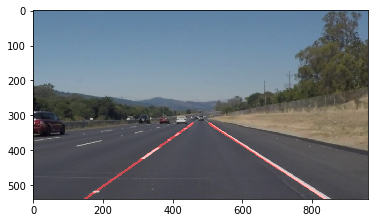

In [6]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
%matplotlib inline
# Define the interested region
def region_of_interest(img, vertices):
    mask = np.zeros_like(img)
    match_mask_color = 255
    cv2.fillPoly(mask, vertices, match_mask_color)
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image
# Draw the detected lanes on image
def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    #Copy the original image
    im = np.copy(img)
    # exit if no line is detected
    if lines is None:
        return
    # Create a blank image to draw on
    line_img = np.zeros( (im.shape[0], im.shape[1], 3 ), dtype = np.uint8 )
    # Loop over the blank image to draw line
    for line in lines:
        for x1, y1, x2, y2 in line:
            cv2.line(line_img, (x1, y1), (x2, y2), color, thickness)
    # Merge drawn lines with original image.
    image_line = cv2.addWeighted(img, 0.8, line_img, 0.5, 0.0)
    return image_line

# Main function
def image_process(image):
    #Copy the original image
    im = np.copy(image)
    #Get image size
    height = im.shape[0]
    width = im.shape[1]
    #Define region of  interest - from bottom to middle of the image
    region_of_interest_vertices = [(0, height), (width/2, height/2), (width, height)]
    #Convert image to grayscale
    gray_image = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)
    #Apply Canny edge detection - thresholds selected as 70-150
    canny_image = cv2.Canny(gray_image, 70, 150)
    #Get the relevant area of the image
    cropped_image = region_of_interest(canny_image, np.array([region_of_interest_vertices], np.int32))
    #Apply Hough Transform
    lines = cv2.HoughLinesP(cropped_image, rho=6,theta=np.pi / 180, threshold=160, lines=np.array([]), minLineLength=40, maxLineGap=25)
    #Draw the lines on original image - draw_lines is commentted out, because we need to extend the lines on lane segments
    #line_image = draw_lines(image, lines)
    
    # To extend the lines first group the lanes by checking slope value
    #Find the left and right lanes
    left_x = []
    left_y = []
    right_x = []
    right_y = []
    for line in lines:
        for x1, y1, x2, y2 in line:
            slope = (y2 - y1) / (x2 - x1)
            # Define threshold value for slope (if threshold is too small I've noticed some slipping on the lines)
            if math.fabs(slope) < 0.5:
                continue
            #Group the lines by checking the sign of slope    
            if slope <= 0: 
                left_x.extend([x1, x2])
                left_y.extend([y1, y2])
            else: 
                right_x.extend([x1, x2])
                right_y.extend([y1, y2])

    # Fit polynomials (1 dimensional) for left and rigth lanes
    poly_left = np.poly1d(np.polyfit(left_y, left_x, deg=1))
    poly_right = np.poly1d(np.polyfit(right_y, right_x, deg=1))
    
    # Define Min and Max points for x and y axes as start and end points for lines.
    # 0.6 is an arbitrary value below the horizon
    min_y = int(image.shape[0] * 0.6) 
    max_y = int(image.shape[0])
    
    left_x_start = int(poly_left(max_y))
    left_x_end = int(poly_left(min_y))

    
    right_x_start = int(poly_right(max_y))
    right_x_end = int(poly_right(min_y))
    
    #Draw lines on top of original image
    line_image = draw_lines(image, [[[left_x_start, max_y, left_x_end, min_y], [right_x_start, max_y, right_x_end, min_y]]], thickness=5)
    return line_image

#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
result = image_process(image)
#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(result)